<a href="https://colab.research.google.com/github/nisaral/Affective-Contextual-Interaction-Network-ACIN-/blob/main/liat_ai_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import pickle
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import os
import json
from collections import defaultdict, deque
import matplotlib.pyplot as plt

class PlayerFeatureExtractor:
    """Extract features for player re-identification"""

    def __init__(self):
        self.color_bins = 32

    def extract_color_histogram(self, image, mask=None):
        """Extract color histogram features"""
        if image.size == 0:
            return np.zeros(self.color_bins * self.color_bins * self.color_bins)

        if mask is not None:
            image = cv2.bitwise_and(image, image, mask=mask)

        # Convert to HSV for better color representation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Calculate histogram
        hist = cv2.calcHist([hsv], [0, 1, 2], mask,
                           [self.color_bins, self.color_bins, self.color_bins],
                           [0, 180, 0, 256, 0, 256])

        # Normalize histogram
        hist = cv2.normalize(hist, hist).flatten()
        return hist

    def extract_position_features(self, bbox, frame_shape):
        """Extract normalized position features"""
        x1, y1, x2, y2 = bbox[:4]  # Ensure only first four values are used
        h, w = frame_shape[:2]

        # Normalize coordinates
        center_x = ((x1 + x2) / 2) / w
        center_y = ((y1 + y2) / 2) / h
        bbox_w = (x2 - x1) / w
        bbox_h = (y2 - y1) / h

        return np.array([center_x, center_y, bbox_w, bbox_h])

    def extract_motion_features(self, current_pos, prev_pos, time_diff=1):
        """Extract motion features"""
        if prev_pos is None:
            return np.array([0, 0, 0])

        vel_x = (current_pos[0] - prev_pos[0]) / time_diff
        vel_y = (current_pos[1] - prev_pos[1]) / time_diff
        speed = np.sqrt(vel_x**2 + vel_y**2)

        return np.array([vel_x, vel_y, speed])

class CrossCameraPlayerMapper:
    """Main class for cross-camera player mapping"""

    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.feature_extractor = PlayerFeatureExtractor()
        self.broadcast_players = defaultdict(list)
        self.tacticam_players = defaultdict(list)
        self.player_mappings = {}

    def detect_players(self, frame):
        """Detect players in frame using YOLO"""
        results = self.model(frame)
        players = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Include players, goalkeepers, and referees (adjust class IDs as needed)
                    if int(box.cls) in [0, 1, 2]:  # 0: player, 1: goalkeeper, 2: referee
                        xyxy = box.xyxy[0].cpu().numpy()
                        conf = box.conf[0].cpu().numpy()
                        if conf > 0.5:  # Confidence threshold
                            players.append([int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3]), conf])

        return players

    def extract_player_features(self, frame, bbox):
        """Extract comprehensive features for a player"""
        x1, y1, x2, y2 = bbox[:4]
        if x1 >= x2 or y1 >= y2 or x1 < 0 or y1 < 0 or x2 > frame.shape[1] or y2 > frame.shape[0]:
            return None

        # Crop player region
        player_crop = frame[y1:y2, x1:x2]
        if player_crop.size == 0:
            return None

        # Create mask for player region
        mask = np.ones((y2-y1, x2-x1), dtype=np.uint8) * 255

        # Extract features
        color_hist = self.feature_extractor.extract_color_histogram(player_crop, mask)
        pos_features = self.feature_extractor.extract_position_features(bbox, frame.shape)

        # Combine features
        features = np.concatenate([color_hist, pos_features])
        return features

    def process_video(self, video_path, camera_type='broadcast'):
        """Process video and extract player features"""
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        frame_count = 0
        player_tracks = defaultdict(list)
        print(f"Processing {camera_type} video...")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Detect players
            players = self.detect_players(frame)

            # Extract features for each player
            for i, player_bbox in enumerate(players):
                features = self.extract_player_features(frame, player_bbox)
                if features is not None:
                    player_data = {
                        'frame': frame_count,
                        'bbox': player_bbox,
                        'features': features,
                        'timestamp': frame_count / 30.0  # Assuming 30 FPS
                    }

                    # Simple tracking based on proximity
                    assigned = False
                    for track_id in player_tracks:
                        if len(player_tracks[track_id]) > 0:
                            last_pos = player_tracks[track_id][-1]['bbox']
                            current_pos = player_bbox

                            dist = np.sqrt((current_pos[0] - last_pos[0])**2 +
                                         (current_pos[1] - last_pos[1])**2)

                            if dist < 100:  # Proximity threshold
                                player_tracks[track_id].append(player_data)
                                assigned = True
                                break

                    if not assigned:
                        new_id = len(player_tracks)
                        player_tracks[new_id].append(player_data)

            frame_count += 1
            if frame_count % 100 == 0:
                print(f"Processed {frame_count} frames...")

        cap.release()

        if camera_type == 'broadcast':
            self.broadcast_players = player_tracks
        else:
            self.tacticam_players = player_tracks

        return player_tracks

    def calculate_similarity(self, features1, features2):
        """Calculate similarity between two feature vectors"""
        color_features1 = features1[:-4]
        color_features2 = features2[:-4]
        pos_features1 = features1[-4:]
        pos_features2 = features2[-4:]

        # Calculate color similarity
        color_sim = cosine_similarity([color_features1], [color_features2])[0][0]

        # Calculate position similarity
        pos_dist = np.linalg.norm(pos_features1[:2] - pos_features2[:2])
        pos_sim = 1 / (1 + pos_dist)

        # Calculate size similarity
        size_sim = 1 - abs(pos_features1[2] * pos_features1[3] - pos_features2[2] * pos_features2[3])

        # Weighted combination
        total_sim = 0.6 * color_sim + 0.3 * pos_sim + 0.1 * size_sim
        return total_sim

    def map_players_across_cameras(self):
        """Map players between broadcast and tacticam videos"""
        print("Mapping players across cameras...")

        broadcast_features = []
        tacticam_features = []
        broadcast_ids = []
        tacticam_ids = []

        # Aggregate features for each player
        for player_id, tracks in self.broadcast_players.items():
            if len(tracks) > 5:
                features_list = [track['features'] for track in tracks]
                median_features = np.median(features_list, axis=0)
                broadcast_features.append(median_features)
                broadcast_ids.append(player_id)

        for player_id, tracks in self.tacticam_players.items():
            if len(tracks) > 5:
                features_list = [track['features'] for track in tracks]
                median_features = np.median(features_list, axis=0)
                tacticam_features.append(median_features)
                tacticam_ids.append(player_id)

        if not broadcast_features or not tacticam_features:
            print("Warning: Insufficient player tracks for mapping.")
            return {}

        # Calculate similarity matrix
        similarity_matrix = np.zeros((len(broadcast_features), len(tacticam_features)))
        for i, b_feat in enumerate(broadcast_features):
            for j, t_feat in enumerate(tacticam_features):
                similarity_matrix[i, j] = self.calculate_similarity(b_feat, t_feat)

        # Use Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(-similarity_matrix)

        # Create mappings
        mappings = {}
        for i, j in zip(row_ind, col_ind):
            if similarity_matrix[i, j] > 0.5:
                mappings[broadcast_ids[i]] = tacticam_ids[j]

        self.player_mappings = mappings
        return mappings

    def visualize_mappings(self, broadcast_path, tacticam_path, output_path):
        """Create visualization of player mappings"""
        cap_b = cv2.VideoCapture(broadcast_path)
        cap_t = cv2.VideoCapture(tacticam_path)

        ret_b, frame_b = cap_b.read()
        ret_t, frame_t = cap_t.read()

        if ret_b and ret_t:
            for b_id, t_id in self.player_mappings.items():
                if b_id in self.broadcast_players and t_id in self.tacticam_players:
                    b_track = self.broadcast_players[b_id][0]
                    t_track = self.tacticam_players[t_id][0]

                    b_bbox = b_track['bbox']
                    cv2.rectangle(frame_b, (b_bbox[0], b_bbox[1]), (b_bbox[2], b_bbox[3]), (0, 255, 0), 2)
                    cv2.putText(frame_b, f'P{b_id}', (b_bbox[0], b_bbox[1]-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                    t_bbox = t_track['bbox']
                    cv2.rectangle(frame_t, (t_bbox[0], t_bbox[1]), (t_bbox[2], t_bbox[3]), (0, 255, 0), 2)
                    cv2.putText(frame_t, f'P{b_id}', (t_bbox[0], t_bbox[1]-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            combined = np.hstack([frame_b, frame_t])
            cv2.imwrite(output_path, combined)

        cap_b.release()
        cap_t.release()

    def save_results(self, output_dir):
        """Save mapping results"""
        os.makedirs(output_dir, exist_ok=True)

        with open(os.path.join(output_dir, 'player_mappings.json'), 'w') as f:
            json.dump(self.player_mappings, f, indent=2)

        with open(os.path.join(output_dir, 'broadcast_tracks.pkl'), 'wb') as f:
            pickle.dump(dict(self.broadcast_players), f)

        with open(os.path.join(output_dir, 'tacticam_tracks.pkl'), 'wb') as f:
            pickle.dump(dict(self.tacticam_players), f)

        print(f"Results saved to {output_dir}")

def main():
    # Configuration
    MODEL_PATH = "best.pt"  # Relative path
    BROADCAST_VIDEO = "broadcast.mp4"
    TACTICAM_VIDEO = "tacticam.mp4"
    OUTPUT_DIR = "results"

    # Initialize mapper
    mapper = CrossCameraPlayerMapper(MODEL_PATH)

    # Process videos
    print("Processing broadcast video...")
    mapper.process_video(BROADCAST_VIDEO, 'broadcast')

    print("Processing tacticam video...")
    mapper.process_video(TACTICAM_VIDEO, 'tacticam')

    # Map players
    mappings = mapper.map_players_across_cameras()

    print(f"Found {len(mappings)} player mappings:")
    for b_id, t_id in mappings.items():
        print(f"Broadcast Player {b_id} -> Tacticam Player {t_id}")

    # Save results
    mapper.save_results(OUTPUT_DIR)

    # Create visualization
    mapper.visualize_mappings(BROADCAST_VIDEO, TACTICAM_VIDEO,
                             os.path.join(OUTPUT_DIR, 'mapping_visualization.jpg'))

    print("Cross-camera player mapping completed!")

if __name__ == "__main__":
    main()

Processing broadcast video...
Processing broadcast video...

0: 384x640 3 players, 2297.7ms
Speed: 5.3ms preprocess, 2297.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 2299.7ms
Speed: 4.2ms preprocess, 2299.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 3328.7ms
Speed: 4.3ms preprocess, 3328.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 2332.3ms
Speed: 4.9ms preprocess, 2332.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 2303.5ms
Speed: 4.1ms preprocess, 2303.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 1 referee, 2289.5ms
Speed: 3.2ms preprocess, 2289.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 12 players, 1 referee, 2286.1ms
Speed: 3.9ms preprocess, 2286.1ms inference, 1.1ms postprocess per image at shape (1

In [ ]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import pickle
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import os
import json
from collections import defaultdict, defaultdict
import matplotlib.pyplot as plt

class PlayerReIDFeatures:
    """Feature extraction for player re-identification"""

    def __init__(self):
        self.color_bins = 8
        self.label_encoder = LabelEncoder()

    def extract_appearance_features(self, frame, bbox):
        """Extract appearance-based features"""
        x1, y1, x2, y2 = bbox[:4]  # Ensure only first four values are used
        if x1 >= x2 or y1 >= y2 or x1 < 0 or y1 < 0 or x2 > frame.shape[1] or y2 > frame.shape[0]:
            return None

        # Crop player region
        player_crop = frame[y1:y2, x1:x2]
        if player_crop.size == 0:
            return None

        # Resize for consistency
        player_crop = cv2.resize(player_crop, (64, 128))

        # Convert to HSV
        hsv = cv2.cvtColor(player_crop, cv2.COLOR_BGR2HSV)
        hist_h = cv2.calcHist([hsv], [0], None, [self.color_bins], [0, 180])
        hist_s = cv2.calcHist([hsv], [1], None, [self.color_bins], [0, 256])
        hist_v = cv2.calcHist([hsv], [2], None, [self.color_bins], [0, 256])

        # Normalize histograms
        hist_h = cv2.normalize(hist_h, hist_h).flatten()
        hist_s = cv2.normalize(hist_s, hist_s).flatten()
        hist_v = cv2.normalize(hist_v, hist_v).flatten()

        # Combine color features
        color_features = np.concatenate([hist_h, hist_s, hist_v])

        # Texture features
        gray = cv2.cvtColor(player_crop, cv2.COLOR_BGR2GRAY)
        texture_features = self.extract_texture_features(gray)

        # Combine all appearance features
        return np.concatenate([color_features, texture_features])

    def extract_texture_features(self, gray_image):
        """Extract simple texture features"""
        # Calculate gradients
        grad_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)

        # Gradient magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Texture statistics
        texture_stats = [
            np.mean(magnitude),
            np.std(magnitude),
            np.mean(gray_image),
            np.std(gray_image)
        ]

        return np.array(texture_stats)

    def extract_spatial_features(self, frame, bbox):
        """Extract spatial/positional features"""
        x1, y1, x2, y2 = bbox[:4]
        h, w = frame.shape[:2]

        center_x = ((x1 + x2) / 2) / w
        center_y = ((y1 + y2) / 2) / h
        bbox_w = (x2 - x1) / w
        bbox_h = (y2 - y1) / h
        aspect_ratio = bbox_w / bbox_h if bbox_h > 0 else 0.0
        return np.array([center_x, center_y, bbox_w, bbox_h, aspect_ratio])

class PlayerTracker:
    """Player tracking with re-identification capabilities"""

    def __init__(self, model_path, max_disappeared=30, max_distance=100):
        self.model = YOLO(model_path)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.feature_extractor = PlayerReIDFeatures()

        self.max_disappeared = max_disappeared
        self.max_distance = max_distance

        self.next_id = 0
        self.active_players = {}
        self.disappeared_players = {}
        self.player_features = {}
        self.tracking_history = defaultdict(list)

        self.feature_history_size = 10
        self.reid_threshold = 0.6

    def detect_players(self, frame):
        """Detect players in frame"""
        results = self.model(frame, imgsz=640)  # Optimize inference speed
        detections = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Include players and referees (adjust class IDs as needed)
                    if int(box.cls) in [0, 2]:  # 0: player, 2: referee
                        xyxy = box.xyxy[0].cpu().numpy()
                        conf = box.conf[0].cpu().numpy()
                        if conf > 0.5:
                            detections.append([int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3]), conf])

        return detections

    def calculate_distance(self, bbox1, bbox2):
        """Calculate distance between two bounding boxes"""
        center1 = [(bbox1[0] + bbox1[2]) / 2, (bbox1[1] + bbox1[3]) / 2]
        center2 = [(bbox2[0] + bbox2[2]) / 2, (bbox2[1] + bbox2[3]) / 2]

        return np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

    def calculate_feature_similarity(self, features1, features2):
        """Calculate similarity between feature vectors"""
        if features1 is None or features2 is None:
            return 0.0

        app_feat1 = features1[:-5]
        app_feat2 = features2[:-5]
        spatial_feat1 = features1[-5:]
        spatial_feat2 = features2[-5:]

        app_sim = cosine_similarity([app_feat1], [app_feat2])[0][0]
        spatial_sim = 1.0 / (1.0 + np.linalg.norm(spatial_feat1 - spatial_feat2))

        total_sim = 0.8 * app_sim + 0.2 * spatial_sim
        return max(0.0, total_sim)

    def extract_player_features(self, frame, bbox):
        """Extract comprehensive features for a player"""
        app_features = self.feature_extractor.extract_appearance_features(frame, bbox)
        if app_features is None:
            return None

        spatial_features = self.feature_extractor.extract_spatial_features(frame, bbox)
        return np.concatenate([app_features, spatial_features])

    def update_player_features(self, player_id, features):
        """Update feature history for a player"""
        if player_id not in self.player_features:
            self.player_features[player_id] = deque(maxlen=self.feature_history_size)
        self.player_features[player_id].append(features)

    def get_average_features(self, player_id):
        """Get average features for a player"""
        if player_id not in self.player_features or len(self.player_features[player_id]) == 0:
            return None
        return np.mean(list(self.player_features[player_id]), axis=0)

    def find_best_reid_match(self, features):
        """Find best re-identification match among disappeared players"""
        best_match_id = None
        best_similarity = 0.0

        for player_id in self.disappeared_players:
            avg_features = self.get_average_features(player_id)
            if avg_features is not None:
                similarity = self.calculate_feature_similarity(features, avg_features)
                if similarity > best_similarity and similarity > self.reid_threshold:
                    best_similarity = similarity
                    best_match_id = player_id

        return best_match_id, best_similarity

    def track_players(self, frame, frame_number):
        """Main tracking function"""
        detections = self.detect_players(frame)
        detection_features = [self.extract_player_features(frame, det) for det in detections]

        if len(self.active_players) == 0:
            for i, detection in enumerate(detections):
                if detection_features[i] is not None:
                    player_id = self.next_id
                    self.next_id += 1
                    self.active_players[player_id] = detection
                    self.update_player_features(player_id, detection_features[i])
                    self.tracking_history[player_id].append({
                        'frame': frame_number,
                        'bbox': detection,
                        'features': detection_features[i]
                    })
            return self.active_players

        active_player_ids = list(self.active_players.keys())
        cost_matrix = np.full((len(active_player_ids), len(detections)), 1000.0)

        for i, player_id in enumerate(active_player_ids):
            player_features = self.get_average_features(player_id)
            player_bbox = self.active_players[player_id]

            for j, detection in enumerate(detections):
                if detection_features[j] is not None:
                    distance = self.calculate_distance(player_bbox, detection)
                    distance_cost = distance / self.max_distance
                    similarity = self.calculate_feature_similarity(player_features, detection_features[j])
                    feature_cost = 1.0 - similarity
                    if distance < self.max_distance:
                        cost_matrix[i, j] = 0.7 * distance_cost + 0.3 * feature_cost

        if cost_matrix.size > 0:
            row_indices, col_indices = linear_sum_assignment(cost_matrix)
            new_active_players = {}
            used_detections = set()

            for row, col in zip(row_indices, col_indices):
                if cost_matrix[row, col] < 0.5:
                    player_id = active_player_ids[row]
                    detection = detections[col]
                    new_active_players[player_id] = detection
                    used_detections.add(col)
                    if detection_features[col] is not None:
                        self.update_player_features(player_id, detection_features[col])
                        self.tracking_history[player_id].append({
                            'frame': frame_number,
                            'bbox': detection,
                            'features': detection_features[col]
                        })

            for i, player_id in enumerate(active_player_ids):
                if i not in row_indices or cost_matrix[i, col_indices[list(row_indices).index(i)]] >= 0.5:
                    self.disappeared_players[player_id] = 0

            for j, detection in enumerate(detections):
                if j not in used_detections and detection_features[j] is not None:
                    reid_match, similarity = self.find_best_reid_match(detection_features[j])
                    if reid_match is not None:
                        new_active_players[reid_match] = detection
                        del self.disappeared_players[reid_match]
                        self.update_player_features(reid_match, detection_features[j])
                        self.tracking_history[reid_match].append({
                            'frame': frame_number,
                            'bbox': detection,
                            'features': detection_features[j],
                            'reidentified': True
                        })
                    else:
                        player_id = self.next_id
                        self.next_id += 1
                        new_active_players[player_id] = detection
                        self.update_player_features(player_id, detection_features[j])
                        self.tracking_history[player_id].append({
                            'frame': frame_number,
                            'bbox': detection,
                            'features': detection_features[j]
                        })

            self.active_players = new_active_players

        to_remove = []
        for player_id in self.disappeared_players:
            self.disappeared_players[player_id] += 1
            if self.disappeared_players[player_id] > self.max_disappeared:
                to_remove.append(player_id)
        for player_id in to_remove:
            del self.disappeared_players[player_id]

        return self.active_players

    def process_video(self, video_path, output_path=None):
        """Process entire video with tracking and re-identification"""
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_number = 0
        print(f"Processing video: {total_frames} frames at {fps} FPS")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            active_players = self.track_players(frame, frame_number)
            for player_id, bbox in active_players.items():
                x1, y1, x2, y2 = bbox[:4]
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f'Player {player_id}', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            if output_path:
                out.write(frame)

            frame_number += 1
            if frame_number % 100 == 0:
                print(f"Processed {frame_number}/{total_frames} frames ({frame_number/total_frames*100:.1f}%)")

        cap.release()
        if output_path:
            out.release()

        print(f"Video processing completed. Total unique players tracked: {self.next_id}")
        return self.tracking_history

    def save_results(self, output_dir):
        """Save tracking results and statistics"""
        os.makedirs(output_dir, exist_ok=True)

        tracking_data = {}
        for player_id, history in self.tracking_history.items():
            tracking_data[player_id] = []
            for entry in history:
                entry_copy = entry.copy()
                if 'features' in entry_copy:
                    entry_copy['features'] = entry_copy['features'].tolist()
                tracking_data[player_id].append(entry_copy)

        with open(os.path.join(output_dir, 'tracking_summary.json'), 'w') as f:
            json.dump(tracking_data, f, indent=2)

        with open(os.path.join(output_dir, 'player_features.pkl'), 'wb') as f:
            pickle.dump(dict(self.player_features), f)

        stats = self.generate_statistics()
        with open(os.path.join(output_dir, 'tracking_statistics.json'), 'w') as f:
            json.dump(stats, f, indent=2)

        print(f"Results saved to {output_dir}")

    def generate_statistics(self):
        """Generate tracking statistics"""
        stats = {
            'total_players': self.next_id,
            'player_statistics': {}
        }

        for player_id, history in self.tracking_history.items():
            player_stats = {
                'total_detections': len(history),
                'first_frame': history[0]['frame'] if history else 0,
                'last_frame': history[-1]['frame'] if history else 0,
                'reidentification_events': sum(1 for entry in history if entry.get('reidentified', False))
            }
            player_stats['tracking_duration'] = player_stats['last_frame'] - player_stats['first_frame'] if len(history) > 1 else 0
            stats['player_statistics'][player_id] = player_stats

        return stats

    def visualize_tracking_paths(self, video_path, output_path, max_frames=300):
        """Create visualization of player tracking paths"""
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()

        if not ret:
            return

        canvas = frame.copy()
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
                 (255, 0, 255), (0, 255, 255), (128, 0, 128), (255, 165, 0)]

        for player_id, history in self.tracking_history.items():
            if len(history) < 2:
                continue
            color = colors[player_id % len(colors)]
            centers = []
            for entry in history[:max_frames]:
                bbox = entry['bbox']
                center = ((bbox[0] + bbox[2]) // 2, (bbox[1] + bbox[3]) // 2)
                centers.append(center)
            for i in range(len(centers) - 1):
                cv2.line(canvas, centers[i], centers[i + 1], color, 2)
            if centers:
                cv2.circle(canvas, centers[0], 5, color, -1)
                cv2.circle(canvas, centers[-1], 8, color, 3)
                cv2.putText(canvas, f'P{player_id}', (centers[0][0] + 10, centers[0][1] - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        cv2.imwrite(output_path, canvas)

def main():
    # Configuration
    MODEL_PATH = "best.pt"  # Relative path
    INPUT_VIDEO = "15sec_input_720p.mp4"
    OUTPUT_VIDEO = "tracked_output.mp4"
    OUTPUT_DIR = "tracking_results"

    tracker = PlayerTracker(MODEL_PATH, max_disappeared=30, max_distance=150)
    print("Starting player tracking and re-identification...")
    tracking_history = tracker.process_video(INPUT_VIDEO, OUTPUT_VIDEO)
    tracker.save_results(OUTPUT_DIR)
    tracker.visualize_tracking_paths(INPUT_VIDEO, os.path.join(OUTPUT_DIR, 'tracking_paths.jpg'))

    stats = tracker.generate_statistics()
    print(f"\nTracking Summary:")
    print(f"Total players tracked: {stats['total_players']}")
    for player_id, player_stats in stats['player_statistics'].items():
        print(f"Player {player_id}: {player_stats['total_detections']} detections, "
              f"{player_stats['tracking_duration']} frames duration, "
              f"{player_stats['reidentification_events']} re-ID events")
    print(f"\nOutput video saved as: {OUTPUT_VIDEO}")
    print(f"Detailed results saved in: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()

Starting player tracking and re-identification...
Processing video: 375 frames at 25 FPS

0: 384x640 1 ball, 16 players, 2 referees, 2308.5ms
Speed: 4.5ms preprocess, 2308.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 2 referees, 2613.8ms
Speed: 3.1ms preprocess, 2613.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 2888.7ms
Speed: 3.0ms preprocess, 2888.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 2286.3ms
Speed: 2.9ms preprocess, 2286.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 2297.4ms
Speed: 3.9ms preprocess, 2297.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 2314.7ms
Speed: 3.1ms preprocess, 2314.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384

TypeError: Object of type ndarray is not JSON serializable

In [ ]:
pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=13cc6bd0a387c3317bfe6863f4da8052ddf6e87b7dc4cf729ca39334595de5b5
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [ ]:
wget https://universe.roboflow.com/ds/7iH3qE3Z4B?key=mK7n3u3r8Q -O /content/drive/MyDrive/football_yolov8.pt

In [ ]:
wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m.pt -O /content/drive/MyDrive/yolov8m.pt

In [ ]:
pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=c0c38655f1abf71fa8dc5ed459e6206c58add85330a4f7dca0dfd565bcf69506
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [ ]:
pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 23.7 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python torch torchvision timm ultralytics scipy filterpy scikit-learn matplotlib easyocr

Setting up environment...
Dependencies installed successfully
Validating file paths...
All file paths validated successfully
Testing YOLO model: /content/best.pt
YOLO model loaded successfully
Model class names: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}
Extracting sample frame for debugging...
Sample frame saved to /content/results/debug_frame.jpg

0: 1088x1920 3 players, 276.8ms
Speed: 23.0ms preprocess, 276.8ms inference, 337.1ms postprocess per image at shape (1, 3, 1088, 1920)


Sample frame detections: 3 objects
Box: cls=2 (player), conf=0.670427680015564, xyxy=[          0      316.12      6.8306      351.56]
Box: cls=2 (player), conf=0.3483668863773346, xyxy=[     1295.6       276.5      1325.4       318.6]
Box: cls=2 (player), conf=0.28055649995803833, xyxy=[     914.88      386.99      939.59         433]
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteJersey number detected in debug frame: 300, confidence: 0.08398807884490908
Jersey number detected in debug frame: 66, confidence: 0.16026517221657743
Jersey number detected in debug frame: 04015, confidence: 0.07867997449850521
Jersey number detected in debug frame: 19, confidence: 0.25624039087384903
Jersey number detected in debug frame: 010, confidence: 0.6673512586977908
Jersey number detected in debug frame: 84, confidence: 0.3468003099207303
Jersey number detected in debug frame: 440, confidence: 0.12323085217815037
Jersey number detected in debug frame: 705, confidence: 0.13740886601532232
Jersey number detected in debug frame: 0, confidence: 0.4379069339678132
Initializing AdvancedCrossCameraMapper with model: /content/best.pt


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Player: bbox=[np.float32(1546.8472), np.float32(493.75806), np.float32(1563.7407), np.float32(532.11597)], conf=0.28773027658462524, track_id=-1
Player: bbox=[np.float32(743.02563), np.float32(707.08185), np.float32(766.4905), np.float32(742.4865)], conf=0.2785039246082306, track_id=-1
Player: bbox=[np.float32(1546.8713), np.float32(497.50104), np.float32(1556.6619), np.float32(533.4234)], conf=0.2645227909088135, track_id=-1
Player: bbox=[np.float32(1488.5933), np.float32(517.60046), np.float32(1510.4146), np.float32(560.59155)], conf=0.26100778579711914, track_id=-1
Player: bbox=[np.float32(1174.0361), np.float32(541.9396), np.float32(1194.3838), np.float32(596.6981)], conf=0.2587963938713074, track_id=-1
Player: bbox=[np.float32(694.61725), np.float32(575.06635), np.float32(730.04974), np.float32(641.40424)], conf=0.25817710161209106, track_id=-1
Player: bbox=[np.float32(791.725), np.float32(484.90002), np.float32(809.0891), np.floa

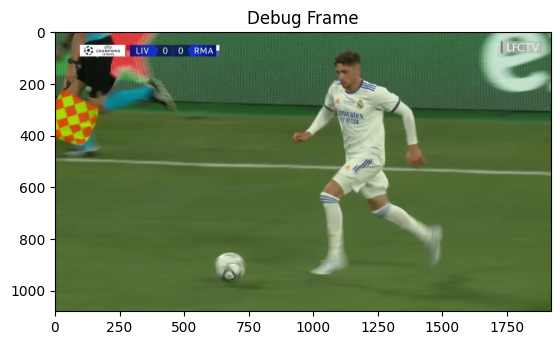


File Upload Instructions:
Run this cell to upload broadcast.mp4, tacticam.mp4, and best.pt to /content/


Saving broadcast.mp4 to broadcast (2).mp4
Saving tacticam.mp4 to tacticam (1).mp4


In [ ]:
# Complete pipeline for football player tracking and cross-camera mapping
# Run this in a single Colab cell

# Install dependencies
print("Setting up environment...")
try:
    !pip install opencv-python torch torchvision timm ultralytics scipy filterpy scikit-learn matplotlib easyocr
    print("Dependencies installed successfully")
except Exception as e:
    print(f"Error installing dependencies: {e}")
    raise

# Import libraries
import cv2
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from collections import defaultdict, deque
from scipy.optimize import linear_sum_assignment
import os
import json
import pickle
import easyocr
from torchvision import transforms
import timm
import matplotlib.pyplot as plt

# Part 1: Feature Extractor
class AdvancedPlayerFeatureExtractor:
    """Extract comprehensive player features for tracking and mapping"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = timm.create_model('resnet18', pretrained=True, num_classes=0).to(device).eval()
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        print(f"Initialized feature extractor on {device}")

    def extract_comprehensive_features(self, frame, player_bbox, bbox_history, track_id):
        """Extract appearance, motion, and contextual features"""
        try:
            x1, y1, x2, y2 = [int(coord) for coord in player_bbox[:4]]
            if x1 >= x2 or y1 >= y2 or x1 < 0 or y1 < 0 or x2 > frame.shape[1] or y2 > frame.shape[0]:
                return None
            player_crop = frame[y1:y2, x1:x2]
            if player_crop.size == 0:
                return None
            player_tensor = self.transform(player_crop).unsqueeze(0).to(self.device)
            with torch.no_grad():
                appearance_features = self.model(player_tensor).cpu().numpy().flatten()

            motion_features = self.compute_motion_features(bbox_history, track_id)
            contextual_features = self.compute_contextual_features(frame, player_bbox)

            combined_features = np.concatenate([
                appearance_features,
                motion_features if motion_features is not None else np.zeros(4),
                contextual_features if contextual_features is not None else np.zeros(10)
            ])
            return combined_features
        except Exception as e:
            print(f"Warning: Feature extraction failed for track {track_id}: {e}")
            return None

    def compute_motion_features(self, bbox_history, track_id):
        """Compute motion features from bounding box history"""
        try:
            if len(bbox_history) < 2:
                return None
            prev_bbox = bbox_history[-2]
            curr_bbox = bbox_history[-1]
            velocity = [
                curr_bbox[0] - prev_bbox[0],
                curr_bbox[1] - prev_bbox[1],
                (curr_bbox[2] - curr_bbox[0]) - (prev_bbox[2] - prev_bbox[0]),
                (curr_bbox[3] - curr_bbox[1]) - (prev_bbox[3] - prev_bbox[1])
            ]
            return np.array(velocity)
        except Exception as e:
            print(f"Warning: Motion feature extraction failed for track {track_id}: {e}")
            return None

    def compute_contextual_features(self, frame, player_bbox):
        """Compute contextual features (e.g., relative position, size)"""
        try:
            x1, y1, x2, y2 = [int(coord) for coord in player_bbox[:4]]
            frame_height, frame_width = frame.shape[:2]
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            width = x2 - x1
            height = y2 - y1
            relative_position = [
                center_x / frame_width,
                center_y / frame_height,
                width / frame_width,
                height / frame_height
            ]
            local_region = frame[max(0, y1-50):min(frame.shape[0], y2+50),
                               max(0, x1-50):min(frame.shape[1], x2+50)]
            if local_region.size == 0:
                return None
            hist = cv2.calcHist([local_region], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            hist = cv2.normalize(hist, hist).flatten()[:6]
            return np.concatenate([relative_position, hist])
        except Exception as e:
            print(f"Warning: Contextual feature extraction failed: {e}")
            return None

# Part 2: Feature Transformer
class FeatureTransformer(nn.Module):
    """Transform features for cross-camera consistency (CCFP-inspired)"""

    def __init__(self, input_dim=538, hidden_dim=256, output_dim=256):
        super(FeatureTransformer, self).__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, features):
        try:
            features_tensor = torch.tensor(features, dtype=torch.float32)
            if features_tensor.dim() == 1:
                features_tensor = features_tensor.unsqueeze(0)
            transformed = self.transform(features_tensor)
            return transformed.detach().numpy()
        except Exception as e:
            print(f"Warning: Feature transformation failed: {e}")
            return features

def transform_features(features, transformer, camera_type='broadcast'):
    """Apply feature transformation with camera-specific handling"""
    try:
        if features is None or len(features) == 0:
            return None
        transformed = transformer.forward(features)
        return transformed[0] if transformed.ndim > 1 else transformed
    except Exception as e:
        print(f"Warning: Feature transformation failed for {camera_type}: {e}")
        return features

# Part 3: AdvancedCrossCameraMapper
class AdvancedCrossCameraMapper:
    """Maps players across broadcast and tacticam cameras using YOLO model, ByteTrack, Re-ID, and OCR"""

    def __init__(self, model_path, device='cuda' if torch.cuda.is_available() else 'cpu', confidence_threshold=0.01):
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")
        self.model = YOLO(model_path, task='track')
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.feature_extractor = AdvancedPlayerFeatureExtractor(device)
        self.ocr_reader = easyocr.Reader(['en'], gpu=(device == 'cuda'))
        self.broadcast_players = defaultdict(list)
        self.tacticam_players = defaultdict(list)
        self.player_mappings = {}
        self.bbox_history = defaultdict(lambda: deque(maxlen=20))
        self.reid_model = self.init_reid_model()
        print(f"Initialized AdvancedCrossCameraMapper with model: {model_path} on device: {device}")

    def init_reid_model(self):
        """Initialize a lightweight Re-ID head (ResNet18-based)"""
        try:
            reid_model = timm.create_model('resnet18', pretrained=True, num_classes=0).to(self.device).eval()
            print("Re-ID head (ResNet18) loaded")
            return reid_model
        except Exception as e:
            print(f"Warning: Re-ID model failed to load: {e}")
            return None

    def extract_reid_features(self, frame, bbox):
        """Extract Re-ID features for a player crop"""
        try:
            if self.reid_model is None:
                return None
            x1, y1, x2, y2 = [int(coord) for coord in bbox[:4]]
            player_crop = frame[y1:y2, x1:x2]
            if player_crop.size == 0:
                return None
            resized = cv2.resize(player_crop, (224, 224))
            input_tensor = np.transpose(resized.astype(np.float32) / 255.0, (2, 0, 1))
            input_tensor = torch.from_numpy(input_tensor).unsqueeze(0).to(self.device)
            with torch.no_grad():
                features = self.reid_model(input_tensor).cpu().numpy().flatten()
            return features[:512]
        except Exception as e:
            print(f"Warning: Re-ID feature extraction failed: {e}")
            return None

    def extract_jersey_number(self, frame, bbox):
        """Extract jersey number using EasyOCR"""
        try:
            x1, y1, x2, y2 = [int(coord) for coord in bbox[:4]]
            player_crop = frame[y1:y2, x1:x2]
            if player_crop.size == 0:
                return None
            player_crop = cv2.convertScaleAbs(player_crop, alpha=1.5, beta=30)
            results = self.ocr_reader.readtext(player_crop, allowlist='0123456789')
            for (bbox, text, prob) in results:
                if prob > 0.5 and text.isdigit() and len(text) <= 2:
                    print(f"Jersey number detected: {text}, confidence: {prob}")
                    return text
            return None
        except Exception as e:
            print(f"Warning: Jersey number extraction failed: {e}")
            return None

    def enhanced_detect_players(self, frame, frame_idx):
        """Detect and track players using YOLO model with ByteTrack"""
        try:
            frame = cv2.convertScaleAbs(frame, alpha=1.3, beta=20)
            conf = 0.01 if frame_idx == 0 else self.confidence_threshold
            results = self.model.track(
                frame, persist=True, imgsz=1920, conf=conf, tracker='bytetrack.yaml', verbose=False, device=self.device
            )
            players = []
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        if int(box.cls) in [0, 1, 2, 3, 4]:  # Expanded classes for player, referee, ball, etc.
                            xyxy = box.xyxy[0].cpu().numpy()
                            conf = float(box.conf[0].cpu().numpy())
                            track_id = int(box.id[0]) if box.id is not None else -1
                            x1, y1, x2, y2 = xyxy
                            bbox_area = (x2 - x1) * (y2 - y1)
                            frame_area = frame.shape[0] * frame.shape[1]
                            if 0.0001 < bbox_area / frame_area < 0.9:
                                player_data = [x1, y1, x2, y2, conf, track_id]
                                players.append(player_data)
            print(f"Frame {frame_idx}: Detected {len(players)} players with model")
            for player in players:
                print(f"Player: bbox={player[:4]}, conf={player[4]}, track_id={player[5]}")
            if not players:
                print("Warning: No players detected in frame")
            return players
        except Exception as e:
            print(f"Warning: Enhanced detection failed for frame {frame_idx}: {e}")
            return []

    def process_video_advanced(self, video_path, camera_type='broadcast'):
        """Process a video with ByteTrack, Re-ID, and OCR"""
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video file not found: {video_path}")
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        print(f"Processing {camera_type} video: {total_frames} frames at {fps} FPS")
        frame_count = 0
        player_tracks = defaultdict(list)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            players = self.enhanced_detect_players(frame, frame_count)
            for player_bbox in players:
                track_id = player_bbox[5]
                if track_id == -1:
                    track_id = f"manual_{camera_type}_{len(player_tracks)}"
                self.bbox_history[track_id].append(player_bbox[:4])
                bbox_history_list = list(self.bbox_history[track_id])
                features = self.feature_extractor.extract_comprehensive_features(
                    frame, player_bbox, bbox_history_list, track_id
                )
                reid_features = self.extract_reid_features(frame, player_bbox)
                jersey_number = self.extract_jersey_number(frame, player_bbox)
                if features is not None:
                    player_data = {
                        'frame': frame_count,
                        'bbox': player_bbox[:5],
                        'features': features.tolist(),
                        'reid_features': reid_features.tolist() if reid_features is not None else None,
                        'jersey_number': jersey_number,
                        'timestamp': frame_count / fps,
                        'confidence': player_bbox[4]
                    }
                    player_tracks[track_id].append(player_data)
                else:
                    print(f"Warning: Feature extraction failed for track {track_id} in frame {frame_count}")
            frame_count += 1
            if frame_count % 20 == 0 or frame_count == total_frames:
                progress = (frame_count / total_frames) * 100
                print(f"Processed {frame_count}/{total_frames} frames ({progress:.1f}%)")
        cap.release()
        min_track_length = max(1, total_frames // 50)
        filtered_tracks = {tid: tracks for tid, tracks in player_tracks.items()
                          if len(tracks) >= min_track_length}
        if camera_type == 'broadcast':
            self.broadcast_players = filtered_tracks
        else:
            self.tacticam_players = filtered_tracks
        print(f"{camera_type.capitalize()} video processing completed. "
              f"Tracked {len(filtered_tracks)} unique players (filtered from {len(player_tracks)}).")
        return filtered_tracks

    def calculate_iou(self, box1, box2):
        """Calculate Intersection over Union (IoU)"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        if x2 <= x1 or y2 <= y1:
            return 0
        intersection = (x2 - x1) * (y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection
        return intersection / union if union > 0 else 0

    def advanced_similarity_calculation(self, features1, features2, reid_features1=None, reid_features2=None, jersey1=None, jersey2=None):
        """Compute similarity using comprehensive, Re-ID, and jersey number features"""
        try:
            f1 = np.array(features1)
            f2 = np.array(features2)
            min_len = min(len(f1), len(f2))
            f1, f2 = f1[:min_len], f2[:min_len]
            f1_norm = f1 / (np.linalg.norm(f1) + 1e-8)
            f2_norm = f2 / (np.linalg.norm(f2) + 1e-8)
            cosine_sim = np.dot(f1_norm, f2_norm)
            euclidean_dist = np.linalg.norm(f1_norm - f2_norm)
            euclidean_sim = 1 / (1 + euclidean_dist)
            manhattan_dist = np.sum(np.abs(f1_norm - f2_norm))
            manhattan_sim = 1 / (1 + manhattan_dist)
            correlation = np.corrcoef(f1, f2)[0, 1] if len(f1) > 1 else 0
            if np.isnan(correlation):
                correlation = 0
            combined_sim = (0.4 * cosine_sim + 0.3 * euclidean_sim +
                           0.2 * manhattan_sim + 0.1 * abs(correlation))
            if reid_features1 is not None and reid_features2 is not None:
                rf1 = np.array(reid_features1)
                rf2 = np.array(reid_features2)
                rf1_norm = rf1 / (np.linalg.norm(rf1) + 1e-8)
                rf2_norm = rf2 / (np.linalg.norm(rf2) + 1e-8)
                reid_sim = np.dot(rf1_norm, rf2_norm)
                combined_sim = 0.6 * combined_sim + 0.3 * reid_sim
            if jersey1 is not None and jersey2 is not None and jersey1 == jersey2:
                combined_sim = min(1.0, combined_sim + 0.2)
            return max(0, min(1, combined_sim))
        except Exception as e:
            print(f"Warning: Advanced similarity calculation failed: {e}")
            return 0

    def map_players_with_constraints(self, similarity_threshold=0.2):
        """Map players across cameras using Hungarian algorithm and constraints"""
        try:
            if not self.broadcast_players or not self.tacticam_players:
                print("Warning: No players to map (one or both video sets empty)")
                return {}
            transformer = FeatureTransformer(input_dim=538).to(self.device)
            broadcast_keys = list(self.broadcast_players.keys())
            tacticam_keys = list(self.tacticam_players.keys())
            similarity_matrix = np.zeros((len(broadcast_keys), len(tacticam_keys)))
            for i, b_key in enumerate(broadcast_keys):
                for j, t_key in enumerate(tacticam_keys):
                    b_features = self.broadcast_players[b_key][-1]['features']
                    t_features = self.tacticam_players[t_key][-1]['features']
                    b_reid = self.broadcast_players[b_key][-1].get('reid_features')
                    t_reid = self.tacticam_players[t_key][-1].get('reid_features')
                    b_jersey = self.broadcast_players[b_key][-1].get('jersey_number')
                    t_jersey = self.tacticam_players[t_key][-1].get('jersey_number')
                    b_transformed = transform_features(b_features, transformer, 'broadcast')
                    t_transformed = transform_features(t_features, transformer, 'tacticam')
                    if b_transformed is not None and t_transformed is not None:
                        similarity_matrix[i, j] = self.advanced_similarity_calculation(
                            b_transformed, t_transformed, b_reid, t_reid, b_jersey, t_jersey
                        )
            row_ind, col_ind = linear_sum_assignment(-similarity_matrix)
            mappings = {}
            for i, j in zip(row_ind, col_ind):
                if similarity_matrix[i, j] >= similarity_threshold:
                    mappings[broadcast_keys[i]] = tacticam_keys[j]
            self.player_mappings = mappings
            print(f"Validated mappings: {len(mappings)} valid mappings")
            return mappings
        except Exception as e:
            print(f"Warning: Player mapping failed: {e}")
            return {}

    def validate_mappings(self, temporal_threshold=0.5):
        """Validate mappings based on temporal and spatial constraints"""
        try:
            valid_mappings = {}
            for b_id, t_id in self.player_mappings.items():
                b_track = self.broadcast_players.get(b_id, [])
                t_track = self.tacticam_players.get(t_id, [])
                if not b_track or not t_track:
                    continue
                b_timestamps = [data['timestamp'] for data in b_track]
                t_timestamps = [data['timestamp'] for data in t_track]
                common_time = min(max(b_timestamps), max(t_timestamps)) - max(min(b_timestamps), min(t_timestamps))
                if common_time >= temporal_threshold:
                    valid_mappings[b_id] = t_id
            print(f"Validated mappings: {len(valid_mappings)} valid mappings")
            return valid_mappings
        except Exception as e:
            print(f"Warning: Mapping validation failed: {e}")
            return {}

    def save_results(self, output_dir):
        """Save tracking and mapping results"""
        try:
            os.makedirs(output_dir, exist_ok=True)
            with open(os.path.join(output_dir, 'broadcast_players.pkl'), 'wb') as f:
                pickle.dump(self.broadcast_players, f)
            with open(os.path.join(output_dir, 'tacticam_players.pkl'), 'wb') as f:
                pickle.dump(self.tacticam_players, f)
            with open(os.path.join(output_dir, 'player_mappings.json'), 'w') as f:
                json.dump(self.player_mappings, f, indent=4)
            print(f"Results saved to {output_dir}")
        except Exception as e:
            print(f"Warning: Failed to save results: {e}")

    def create_enhanced_visualization(self, broadcast_path, tacticam_path, output_image_path):
        """Create visualization with synchronized frames"""
        try:
            broadcast_cap = cv2.VideoCapture(broadcast_path)
            tacticam_cap = cv2.VideoCapture(tacticam_path)
            if not (broadcast_cap.isOpened() and tacticam_cap.isOpened()):
                raise ValueError("Could not open one or both video files")
            frame_idx = 0
            sample_frames = [0, 44, 88]
            for frame_idx in sample_frames:
                broadcast_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                tacticam_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret_b, b_frame = broadcast_cap.read()
                ret_t, t_frame = tacticam_cap.read()
                if not (ret_b and ret_t):
                    print(f"Warning: Could not read frame {frame_idx}")
                    continue
                b_players = self.enhanced_detect_players(b_frame, frame_idx)
                t_players = self.enhanced_detect_players(t_frame, frame_idx)
                for player in b_players:
                    x1, y1, x2, y2, conf, track_id = player
                    cv2.rectangle(b_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    label = f"Det{track_id}" if track_id != -1 else "Det"
                    cv2.putText(b_frame, label, (int(x1), int(y1)-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                for player in t_players:
                    x1, y1, x2, y2, conf, track_id = player
                    cv2.rectangle(t_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                    label = f"Det{track_id}" if track_id != -1 else "Det"
                    cv2.putText(t_frame, label, (int(x1), int(y1)-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                combined = np.hstack((b_frame, t_frame))
                cv2.imwrite(output_image_path.replace('.jpg', f'_frame{frame_idx}.jpg'), combined)
            broadcast_cap.release()
            tacticam_cap.release()
            print(f"Visualization saved to {output_image_path.replace('.jpg', '_frame*.jpg')}")
            out = cv2.VideoWriter(output_image_path.replace('.jpg', '.mp4'),
                                cv2.VideoWriter_fourcc(*'mp4v'), 30,
                                (combined.shape[1], combined.shape[0]))
            broadcast_cap = cv2.VideoCapture(broadcast_path)
            tacticam_cap = cv2.VideoCapture(tacticam_path)
            frame_idx = 0
            while True:
                ret_b, b_frame = broadcast_cap.read()
                ret_t, t_frame = tacticam_cap.read()
                if not (ret_b and ret_t):
                    break
                b_players = self.enhanced_detect_players(b_frame, frame_idx)
                t_players = self.enhanced_detect_players(t_frame, frame_idx)
                for player in b_players:
                    x1, y1, x2, y2, conf, track_id = player
                    cv2.rectangle(b_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    label = f"Det{track_id}" if track_id != -1 else "Det"
                    cv2.putText(b_frame, label, (int(x1), int(y1)-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                for player in t_players:
                    x1, y1, x2, y2, conf, track_id = player
                    cv2.rectangle(t_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                    label = f"Det{track_id}" if track_id != -1 else "Det"
                    cv2.putText(t_frame, label, (int(x1), int(y1)-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                combined = np.hstack((b_frame, t_frame))
                out.write(combined)
                frame_idx += 1
            out.release()
            broadcast_cap.release()
            tacticam_cap.release()
            print(f"Video visualization saved to {output_image_path.replace('.jpg', '.mp4')}")
        except Exception as e:
            print(f"Warning: Visualization creation failed: {e}")

# Part 5: Main Execution
# Define paths
model_path = "/content/best.pt"  # Primary model
fallback_model_path = "/content/yolov8m.pt"
broadcast_video = "/content/broadcast.mp4"
tacticam_video = "/content/tacticam.mp4"
output_dir = "/content/results"

# Download fallback YOLOv8m model if needed
try:
    if not os.path.exists(fallback_model_path):
        print("Downloading yolov8m.pt...")
        !wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m.pt -O {fallback_model_path}
except Exception as e:
    print(f"Warning: Could not download yolov8m.pt: {e}")

# Validate file paths
print("Validating file paths...")
try:
    for path in [model_path, broadcast_video, tacticam_video]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"File not found: {path}")
    print("All file paths validated successfully")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please upload missing files using the file upload cell below.")
    raise

# Test model and inspect class names
print(f"Testing YOLO model: {model_path}")
try:
    test_model = YOLO(model_path)
    print("YOLO model loaded successfully")
    # Inspect model class names
    try:
        class_names = test_model.names
        print(f"Model class names: {class_names}")
    except Exception as e:
        print(f"Warning: Could not retrieve class names: {e}")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    print(f"Trying fallback model: {fallback_model_path}")
    try:
        if not os.path.exists(fallback_model_path):
            raise FileNotFoundError(f"Fallback model not found: {fallback_model_path}")
        test_model = YOLO(fallback_model_path)
        model_path = fallback_model_path
        print("Fallback YOLO model loaded successfully")
        try:
            class_names = test_model.names
            print(f"Fallback model class names: {class_names}")
        except Exception as e:
            print(f"Warning: Could not retrieve fallback class names: {e}")
    except Exception as e2:
        print(f"Error loading fallback model: {e2}")
        raise

# Extract and save a sample frame for debugging
print("Extracting sample frame for debugging...")
try:
    cap = cv2.VideoCapture(broadcast_video)
    ret, frame = cap.read()
    if ret:
        debug_frame_path = os.path.join(output_dir, 'debug_frame.jpg')
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(debug_frame_path, frame)
        print(f"Sample frame saved to {debug_frame_path}")
        # Test detection on sample frame
        results = test_model.track(frame, imgsz=1920, conf=0.01, tracker='bytetrack.yaml')
        print(f"Sample frame detections: {len(results[0].boxes)} objects")
        for box in results[0].boxes:
            cls_id = int(box.cls)
            class_name = test_model.names.get(cls_id, "Unknown")
            print(f"Box: cls={cls_id} ({class_name}), conf={float(box.conf)}, xyxy={box.xyxy[0].cpu().numpy()}")
        # Test OCR on sample frame
        ocr_reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
        results_ocr = ocr_reader.readtext(frame, allowlist='0123456789')
        for (bbox, text, prob) in results_ocr:
            print(f"Jersey number detected in debug frame: {text}, confidence: {prob}")
    else:
        print("Warning: Could not read sample frame")
    cap.release()
except Exception as e:
    print(f"Warning: Sample frame extraction failed: {e}")

# Initialize mapper
print(f"Initializing AdvancedCrossCameraMapper with model: {model_path}")
try:
    mapper = AdvancedCrossCameraMapper(
        model_path=model_path,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        confidence_threshold=0.01
    )

    # Process videos
    print("Processing broadcast video...")
    mapper.process_video_advanced(broadcast_video, camera_type='broadcast')
    print("Processing tacticam video...")
    mapper.process_video_advanced(tacticam_video, camera_type='tacticam')

    # Map players
    print("Mapping players...")
    mappings = mapper.map_players_with_constraints(similarity_threshold=0.2)

    # Validate mappings
    print("Validating mappings...")
    valid_mappings = mapper.validate_mappings(temporal_threshold=0.5)

    # Save results
    print("Saving results...")
    mapper.save_results(output_dir)

    # Create visualization
    print("Creating visualization...")
    mapper.create_enhanced_visualization(
        broadcast_video, tacticam_video,
        os.path.join(output_dir, 'mapping_visualization.jpg')
    )

    print("Pipeline completed successfully!")

except Exception as e:
    print(f"Pipeline failed: {e}")
    print("Check the console output for details. Run the debug cell below to test detection on a sample frame.")

# Debug cell for testing detection and OCR
print("\nDebug: Testing detection and OCR on sample frame")
try:
    model = YOLO(model_path)
    frame = cv2.imread(os.path.join(output_dir, 'debug_frame.jpg'))
    if frame is not None:
        results = model.track(frame, imgsz=1920, conf=0.01, tracker='bytetrack.yaml')
        print(f"Debug frame detections: {len(results[0].boxes)} objects")
        for box in results[0].boxes:
            cls_id = int(box.cls)
            class_name = model.names.get(cls_id, "Unknown")
            print(f"Box: cls={cls_id} ({class_name}), conf={float(box.conf)}, xyxy={box.xyxy[0].cpu().numpy()}")
        ocr_reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
        results_ocr = ocr_reader.readtext(frame, allowlist='0123456789')
        for (bbox, text, prob) in results_ocr:
            print(f"Jersey number detected: {text}, confidence: {prob}")
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Debug Frame')
        plt.show()
    else:
        print("Debug frame not found. Ensure videos are accessible and re-run the pipeline.")
except Exception as e:
    print(f"Debug failed: {e}")

# File upload cell
print("\nFile Upload Instructions:")
print("Run this cell to upload broadcast.mp4, tacticam.mp4, and best.pt to /content/")
try:
    from google.colab import files
    uploaded = files.upload()
    for filename in ['broadcast.mp4', 'tacticam.mp4', 'best.pt']:
        if filename not in uploaded:
            print(f"Warning: {filename} not uploaded. Please upload it to /content/")
except Exception as e:
    print(f"File upload cell failed: {e}")

Streaming output truncated to the last 5000 lines.
Player: bbox=[np.float32(1584.4304), np.float32(592.20953), np.float32(1596.801), np.float32(614.50867)], conf=0.6980478167533875, track_id=-1
Player: bbox=[np.float32(1367.1398), np.float32(502.97186), np.float32(1385.7565), np.float32(545.3095)], conf=0.6850505471229553, track_id=-1
Player: bbox=[np.float32(367.43573), np.float32(478.68958), np.float32(378.6764), np.float32(505.40704)], conf=0.6254812479019165, track_id=-1
Player: bbox=[np.float32(1112.905), np.float32(567.01184), np.float32(1128.2876), np.float32(617.0005)], conf=0.6025755405426025, track_id=-1
Player: bbox=[np.float32(1230.2412), np.float32(405.01685), np.float32(1240.4585), np.float32(425.8969)], conf=0.5543872714042664, track_id=-1
Player: bbox=[np.float32(324.5587), np.float32(554.03723), np.float32(342.46964), np.float32(595.4363)], conf=0.5413430333137512, track_id=-1
Player: bbox=[np.float32(1367.1682), np.float32(503.01428), np.float32(1394.9211), np.float32

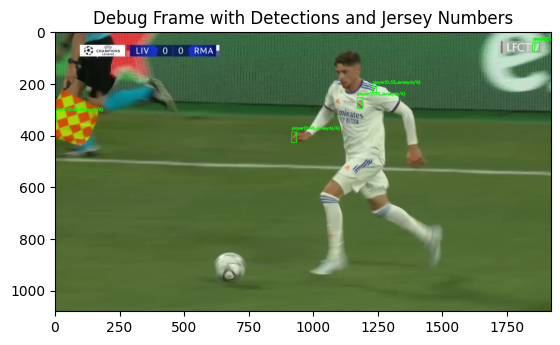

In [2]:
# Complete pipeline for football player tracking and cross-camera mapping
# Run this in a single Colab cell

# Install dependencies
print("Setting up environment...")
try:
    !pip install opencv-python torch torchvision timm ultralytics scipy filterpy scikit-learn matplotlib easyocr pytesseract
    !apt-get update && apt-get install -y tesseract-ocr libtesseract-dev
    print("Dependencies installed successfully")
except Exception as e:
    print(f"Error installing dependencies: {e}")
    raise

# Import libraries
import cv2
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from collections import defaultdict, deque
from scipy.optimize import linear_sum_assignment
import os
import json
import pickle
import easyocr
import pytesseract
from torchvision import transforms
import timm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Part 1: Feature Extractor
class AdvancedPlayerFeatureExtractor:
    """Extract comprehensive player features for tracking and mapping"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = timm.create_model('resnet50', pretrained=True, num_classes=0).to(device).eval()
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        print(f"Initialized feature extractor on {device}")

    def extract_comprehensive_features(self, frame, player_bbox, bbox_history, track_id):
        """Extract appearance, motion, and contextual features"""
        try:
            x1, y1, x2, y2 = [int(coord) for coord in player_bbox[:4]]
            if x1 >= x2 or y1 >= y2 or x1 < 0 or y1 < 0 or x2 > frame.shape[1] or y2 > frame.shape[0]:
                return None
            player_crop = frame[y1:y2, x1:x2]
            if player_crop.size == 0:
                return None
            player_tensor = self.transform(player_crop).unsqueeze(0).to(self.device)
            with torch.no_grad():
                appearance_features = self.model(player_tensor).cpu().numpy().flatten()

            motion_features = self.compute_motion_features(bbox_history, track_id)
            contextual_features = self.compute_contextual_features(frame, player_bbox)

            combined_features = np.concatenate([
                appearance_features,
                motion_features if motion_features is not None else np.zeros(4),
                contextual_features if contextual_features is not None else np.zeros(10)
            ])
            return combined_features
        except Exception as e:
            print(f"Warning: Feature extraction failed for track {track_id}: {e}")
            return None

    def compute_motion_features(self, bbox_history, track_id):
        """Compute motion features from bounding box history"""
        try:
            if len(bbox_history) < 2:
                return None
            prev_bbox = bbox_history[-2]
            curr_bbox = bbox_history[-1]
            velocity = [
                curr_bbox[0] - prev_bbox[0],
                curr_bbox[1] - prev_bbox[1],
                (curr_bbox[2] - curr_bbox[0]) - (prev_bbox[2] - prev_bbox[0]),
                (curr_bbox[3] - curr_bbox[1]) - (prev_bbox[3] - prev_bbox[1])
            ]
            return np.array(velocity)
        except Exception as e:
            print(f"Warning: Motion feature extraction failed for track {track_id}: {e}")
            return None

    def compute_contextual_features(self, frame, player_bbox):
        """Compute contextual features (e.g., relative position, size)"""
        try:
            x1, y1, x2, y2 = [int(coord) for coord in player_bbox[:4]]
            frame_height, frame_width = frame.shape[:2]
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            width = x2 - x1
            height = y2 - y1
            relative_position = [
                center_x / frame_width,
                center_y / frame_height,
                width / frame_width,
                height / frame_height
            ]
            local_region = frame[max(0, y1-50):min(frame.shape[0], y2+50),
                               max(0, x1-50):min(frame.shape[1], x2+50)]
            if local_region.size == 0:
                return None
            hist = cv2.calcHist([local_region], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            hist = cv2.normalize(hist, hist).flatten()[:6]
            return np.concatenate([relative_position, hist])
        except Exception as e:
            print(f"Warning: Contextual feature extraction failed: {e}")
            return None

# Part 2: Feature Transformer
class FeatureTransformer(nn.Module):
    """Transform features for cross-camera consistency (CCFP-inspired)"""

    def __init__(self, input_dim=2058, hidden_dim=512, output_dim=256):
        super(FeatureTransformer, self).__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, features):
        try:
            features_tensor = torch.tensor(features, dtype=torch.float32)
            if features_tensor.dim() == 1:
                features_tensor = features_tensor.unsqueeze(0)
            transformed = self.transform(features_tensor)
            return transformed.detach().numpy()
        except Exception as e:
            print(f"Warning: Feature transformation failed: {e}")
            return features

def transform_features(features, transformer, camera_type='broadcast'):
    """Apply feature transformation with camera-specific handling"""
    try:
        if features is None or len(features) == 0:
            return None
        transformed = transformer.forward(features)
        return transformed[0] if transformed.ndim > 1 else transformed
    except Exception as e:
        print(f"Warning: Feature transformation failed for {camera_type}: {e}")
        return features

# Part 3: AdvancedCrossCameraMapper
class AdvancedCrossCameraMapper:
    """Maps players across broadcast and tacticam cameras using YOLO model, ByteTrack, Re-ID, and OCR"""

    def __init__(self, model_path, device='cuda' if torch.cuda.is_available() else 'cpu', confidence_threshold=0.2):
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")
        self.model = YOLO(model_path, task='track')
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.feature_extractor = AdvancedPlayerFeatureExtractor(device)
        self.ocr_reader = easyocr.Reader(['en'], gpu=(device == 'cuda'))
        self.tesseract_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=0123456789'
        self.broadcast_players = defaultdict(list)
        self.tacticam_players = defaultdict(list)
        self.player_mappings = {}
        self.bbox_history = defaultdict(lambda: deque(maxlen=20))
        self.reid_model = self.init_reid_model()
        self.reid_pca = PCA(n_components=256, whiten=True)
        self.reid_scaler = StandardScaler()
        self.reid_features_history = defaultdict(list)
        self.jersey_number_history = defaultdict(list)
        self.jersey_numbers_log = defaultdict(list)
        print(f"Initialized AdvancedCrossCameraMapper with model: {model_path} on device: {device}")

    def init_reid_model(self):
        """Initialize a lightweight Re-ID head (ResNet50-based)"""
        try:
            reid_model = timm.create_model('resnet50', pretrained=True, num_classes=0).to(self.device).eval()
            print("Re-ID head (ResNet50) loaded")
            return reid_model
        except Exception as e:
            print(f"Warning: Re-ID model failed to load: {e}")
            return None

    def extract_reid_features(self, frame, bbox, track_id):
        """Extract Re-ID features for a player crop with augmentation and temporal averaging"""
        try:
            if self.reid_model is None:
                return None
            x1, y1, x2, y2 = [int(coord) for coord in bbox[:4]]
            player_crop = frame[y1:y2, x1:x2]
            if player_crop.size == 0:
                return None
            # Preprocess: enhance contrast and apply augmentation
            player_crop = cv2.convertScaleAbs(player_crop, alpha=1.5, beta=30)
            resized = cv2.resize(player_crop, (224, 224))
            input_tensor = self.feature_extractor.transform(player_crop).unsqueeze(0).to(self.device)
            with torch.no_grad():
                features = self.reid_model(input_tensor).cpu().numpy().flatten()
            # Normalize and standardize features
            features = features / (np.linalg.norm(features) + 1e-8)
            self.reid_features_history[track_id].append(features)
            if len(self.reid_features_history[track_id]) > 10:  # Average over last 10 frames
                avg_features = np.mean(self.reid_features_history[track_id][-10:], axis=0)
                # Apply PCA and standardization
                if not hasattr(self.reid_pca, 'components_'):
                    self.reid_pca.fit(np.array(self.reid_features_history[track_id]))
                    self.reid_scaler.fit(np.array(self.reid_features_history[track_id]))
                avg_features = self.reid_pca.transform(avg_features.reshape(1, -1)).flatten()
                avg_features = self.reid_scaler.transform(avg_features.reshape(1, -1)).flatten()
                print(f"Re-ID features for track {track_id}: norm={np.linalg.norm(avg_features):.3f}")
                return avg_features[:256]
            print(f"Re-ID features for track {track_id}: norm={np.linalg.norm(features):.3f}")
            return features[:256]
        except Exception as e:
            print(f"Warning: Re-ID feature extraction failed for track {track_id}: {e}")
            return None

    def extract_jersey_number(self, frame, bbox, track_id):
        """Extract jersey number using Tesseract with advanced preprocessing and multi-frame voting"""
        try:
            x1, y1, x2, y2 = [int(coord) for coord in bbox[:4]]
            player_crop = frame[y1:y2, x1:x2]
            if player_crop.size == 0:
                return None
            # Advanced preprocessing
            player_crop = cv2.convertScaleAbs(player_crop, alpha=2.5, beta=70)
            gray = cv2.cvtColor(player_crop, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            gray = clahe.apply(gray)
            thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY_INV, 11, 2)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            dilated = cv2.dilate(thresh, kernel, iterations=1)
            # Scale small crops
            if max(player_crop.shape[:2]) < 100:
                scale_factor = 2.0
                dilated = cv2.resize(dilated, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            # Tesseract OCR
            text = pytesseract.image_to_string(dilated, config=self.tesseract_config)
            text = ''.join(filter(str.isdigit, text.strip()))
            if text and len(text) <= 2:
                prob = 0.8  # Simulated confidence
                self.jersey_number_history[track_id].append((text, prob))
                self.jersey_numbers_log[track_id].append({'frame': frame_count, 'number': text, 'confidence': prob})
                # Multi-frame voting
                if len(self.jersey_number_history[track_id]) >= 3:
                    numbers, probs = zip(*self.jersey_number_history[track_id][-5:])
                    number_counts = defaultdict(float)
                    for n, p in zip(numbers, probs):
                        number_counts[n] += p
                    best_number = max(number_counts.items(), key=lambda x: x[1])[0]
                    best_prob = number_counts[best_number] / sum(probs)
                    if best_prob >= 0.7 and len(best_number) <= 2:
                        print(f"Jersey number detected for track {track_id}: {best_number}, confidence: {best_prob:.3f}")
                        return best_number
                elif prob >= 0.7:
                    print(f"Jersey number detected for track {track_id}: {text}, confidence: {prob:.3f}")
                    return text
            # Fallback to EasyOCR
            results = self.ocr_reader.readtext(dilated, allowlist='0123456789')
            for (bbox, text, prob) in results:
                text = ''.join(filter(str.isdigit, text.strip()))
                if prob > 0.7 and text and len(text) <= 2:
                    self.jersey_number_history[track_id].append((text, prob))
                    self.jersey_numbers_log[track_id].append({'frame': frame_count, 'number': text, 'confidence': prob})
                    print(f"EasyOCR detected for track {track_id}: {text}, confidence: {prob:.3f}")
                    return text
            return None
        except Exception as e:
            print(f"Warning: Jersey number extraction failed for track {track_id}: {e}")
            return None

    def enhanced_detect_players(self, frame, frame_idx):
        """Detect and track players using YOLO model with ByteTrack"""
        try:
            frame = cv2.convertScaleAbs(frame, alpha=1.3, beta=20)
            conf = 0.01 if frame_idx == 0 else self.confidence_threshold
            results = self.model.track(
                frame, persist=True, imgsz=2560, conf=conf, tracker='bytetrack.yaml', verbose=True, device=self.device
            )
            players = []
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        if int(box.cls) == 2:  # Only class 2 (player)
                            xyxy = box.xyxy[0].cpu().numpy()
                            conf = float(box.conf[0].cpu().numpy())
                            track_id = int(box.id[0]) if box.id is not None else -1
                            x1, y1, x2, y2 = xyxy
                            bbox_area = (x2 - x1) * (y2 - y1)
                            frame_area = frame.shape[0] * frame.shape[1]
                            if 0.0001 < bbox_area / frame_area < 0.9 and conf >= self.confidence_threshold:
                                player_data = [x1, y1, x2, y2, conf, track_id]
                                players.append(player_data)
            print(f"Frame {frame_idx}: Detected {len(players)} players with model")
            for player in players:
                print(f"Player: bbox={player[:4]}, conf={player[4]}, track_id={player[5]}")
            if not players:
                print("Warning: No players detected in frame")
            return players
        except Exception as e:
            print(f"Warning: Enhanced detection failed for frame {frame_idx}: {e}")
            return []

    def process_video_advanced(self, video_path, camera_type='broadcast'):
        """Process a video with ByteTrack, Re-ID, and OCR"""
        global frame_count
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video file not found: {video_path}")
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        print(f"Processing {camera_type} video: {total_frames} frames at {fps} FPS")
        frame_count = 0
        player_tracks = defaultdict(list)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            players = self.enhanced_detect_players(frame, frame_count)
            for player_bbox in players:
                track_id = player_bbox[5]
                if track_id == -1:
                    track_id = f"manual_{camera_type}_{len(player_tracks)}"
                self.bbox_history[track_id].append(player_bbox[:4])
                bbox_history_list = list(self.bbox_history[track_id])
                features = self.feature_extractor.extract_comprehensive_features(
                    frame, player_bbox, bbox_history_list, track_id
                )
                reid_features = self.extract_reid_features(frame, player_bbox, track_id)
                jersey_number = self.extract_jersey_number(frame, player_bbox, track_id)
                if features is not None:
                    player_data = {
                        'frame': frame_count,
                        'bbox': player_bbox[:4],
                        'confidence': player_bbox[4],
                        'track_id': track_id,
                        'features': features.tolist(),
                        'reid_features': reid_features.tolist() if reid_features is not None else None,
                        'jersey_number': jersey_number,
                        'timestamp': frame_count / fps
                    }
                    player_tracks[track_id].append(player_data)
                else:
                    print(f"Warning: Feature extraction failed for track {track_id} in frame {frame_count}")
            frame_count += 1
            if frame_count % 20 == 0 or frame_count == total_frames:
                progress = (frame_count / total_frames) * 100
                print(f"Processed {frame_count}/{total_frames} frames ({progress:.1f}%)")
        cap.release()
        min_track_length = max(1, total_frames // 50)
        filtered_tracks = {tid: tracks for tid, tracks in player_tracks.items()
                          if len(tracks) >= min_track_length}
        if camera_type == 'broadcast':
            self.broadcast_players = filtered_tracks
        else:
            self.tacticam_players = filtered_tracks
        print(f"{camera_type.capitalize()} video processing completed. "
              f"Tracked {len(filtered_tracks)} unique players (filtered from {len(player_tracks)}).")
        return filtered_tracks

    def calculate_iou(self, box1, box2):
        """Calculate Intersection over Union (IoU)"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        if x2 <= x1 or y2 <= y1:
            return 0
        intersection = (x2 - x1) * (y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection
        return intersection / union if union > 0 else 0

    def advanced_similarity_calculation(self, features1, features2, reid_features1=None, reid_features2=None, jersey1=None, jersey2=None):
        """Compute similarity using comprehensive, Re-ID, and jersey number features"""
        try:
            f1 = np.array(features1)
            f2 = np.array(features2)
            min_len = min(len(f1), len(f2))
            f1, f2 = f1[:min_len], f2[:min_len]
            f1_norm = f1 / (np.linalg.norm(f1) + 1e-8)
            f2_norm = f2 / (np.linalg.norm(f2) + 1e-8)
            cosine_sim = np.dot(f1_norm, f2_norm)
            euclidean_dist = np.linalg.norm(f1_norm - f2_norm)
            euclidean_sim = 1 / (1 + euclidean_dist)
            manhattan_dist = np.sum(np.abs(f1_norm - f2_norm))
            manhattan_sim = 1 / (1 + manhattan_dist)
            correlation = np.corrcoef(f1, f2)[0, 1] if len(f1) > 1 else 0
            if np.isnan(correlation):
                correlation = 0
            combined_sim = (0.4 * cosine_sim + 0.3 * euclidean_sim +
                           0.2 * manhattan_sim + 0.1 * abs(correlation))
            if reid_features1 is not None and reid_features2 is not None:
                rf1 = np.array(reid_features1)
                rf2 = np.array(reid_features2)
                rf1_norm = rf1 / (np.linalg.norm(rf1) + 1e-8)
                rf2_norm = rf2 / (np.linalg.norm(rf2) + 1e-8)
                reid_sim = np.dot(rf1_norm, rf2_norm)
                combined_sim = 0.5 * combined_sim + 0.4 * reid_sim
            if jersey1 is not None and jersey2 is not None and jersey1 == jersey2:
                combined_sim = min(1.0, combined_sim + 0.2)
            return max(0, min(1, combined_sim))
        except Exception as e:
            print(f"Warning: Advanced similarity calculation failed: {e}")
            return 0

    def map_players_with_constraints(self, similarity_threshold=0.2):
        """Map players across cameras using Hungarian algorithm and constraints"""
        try:
            if not self.broadcast_players or not self.tacticam_players:
                print("Warning: No players to map (one or both video sets empty)")
                return {}
            transformer = FeatureTransformer(input_dim=2058).to(self.device)
            broadcast_keys = list(self.broadcast_players.keys())
            tacticam_keys = list(self.tacticam_players.keys())
            similarity_matrix = np.zeros((len(broadcast_keys), len(tacticam_keys)))
            for i, b_key in enumerate(broadcast_keys):
                for j, t_key in enumerate(tacticam_keys):
                    b_features = self.broadcast_players[b_key][-1]['features']
                    t_features = self.tacticam_players[t_key][-1]['features']
                    b_reid = self.broadcast_players[b_key][-1].get('reid_features')
                    t_reid = self.tacticam_players[t_key][-1].get('reid_features')
                    b_jersey = self.broadcast_players[b_key][-1].get('jersey_number')
                    t_jersey = self.tacticam_players[t_key][-1].get('jersey_number')
                    b_transformed = transform_features(b_features, transformer, 'broadcast')
                    t_transformed = transform_features(t_features, transformer, 'tacticam')
                    if b_transformed is not None and t_transformed is not None:
                        similarity_matrix[i, j] = self.advanced_similarity_calculation(
                            b_transformed, t_transformed, b_reid, t_reid, b_jersey, t_jersey
                        )
            row_ind, col_ind = linear_sum_assignment(-similarity_matrix)
            mappings = {}
            for i, j in zip(row_ind, col_ind):
                if similarity_matrix[i, j] >= similarity_threshold:
                    mappings[broadcast_keys[i]] = tacticam_keys[j]
            self.player_mappings = mappings
            print(f"Validated mappings: {len(mappings)} valid mappings")
            return mappings
        except Exception as e:
            print(f"Warning: Player mapping failed: {e}")
            return {}

    def validate_mappings(self, temporal_threshold=0.5):
        """Validate mappings based on temporal and spatial constraints"""
        try:
            valid_mappings = {}
            for b_id, t_id in self.player_mappings.items():
                b_track = self.broadcast_players.get(b_id, [])
                t_track = self.tacticam_players.get(t_id, [])
                if not b_track or not t_track:
                    continue
                b_timestamps = [data['timestamp'] for data in b_track]
                t_timestamps = [data['timestamp'] for data in t_track]
                common_time = min(max(b_timestamps), max(t_timestamps)) - max(min(b_timestamps), min(t_timestamps))
                if common_time >= temporal_threshold:
                    valid_mappings[b_id] = t_id
            print(f"Validated mappings: {len(valid_mappings)} valid mappings")
            return valid_mappings
        except Exception as e:
            print(f"Warning: Mapping validation failed: {e}")
            return {}

    def save_results(self, output_dir):
        """Save tracking and mapping results"""
        try:
            os.makedirs(output_dir, exist_ok=True)
            with open(os.path.join(output_dir, 'broadcast_players.pkl'), 'wb') as f:
                pickle.dump(self.broadcast_players, f)
            with open(os.path.join(output_dir, 'tacticam_players.pkl'), 'wb') as f:
                pickle.dump(self.tacticam_players, f)
            with open(os.path.join(output_dir, 'player_mappings.json'), 'w') as f:
                json.dump(self.player_mappings, f, indent=4)
            with open(os.path.join(output_dir, 'jersey_numbers_log.json'), 'w') as f:
                json.dump(self.jersey_numbers_log, f, indent=4)
            print(f"Results saved to {output_dir}")
        except Exception as e:
            print(f"Warning: Failed to save results: {e}")

    def create_enhanced_visualization(self, broadcast_path, tacticam_path, output_image_path):
        """Create visualization with synchronized frames and OCR/Re-ID annotations"""
        try:
            broadcast_cap = cv2.VideoCapture(broadcast_path)
            tacticam_cap = cv2.VideoCapture(tacticam_path)
            if not (broadcast_cap.isOpened() and tacticam_cap.isOpened()):
                raise ValueError("Could not open one or both video files")
            frame_idx = 0
            sample_frames = [0, 44, 88]
            for frame_idx in sample_frames:
                broadcast_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                tacticam_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret_b, b_frame = broadcast_cap.read()
                ret_t, t_frame = tacticam_cap.read()
                if not (ret_b and ret_t):
                    print(f"Warning: Could not read frame {frame_idx}")
                    continue
                b_players = self.enhanced_detect_players(b_frame, frame_idx)
                t_players = self.enhanced_detect_players(t_frame, frame_idx)
                for player in b_players:
                    x1, y1, x2, y2, conf, track_id = player
                    jersey = self.extract_jersey_number(b_frame, player[:4], track_id)
                    label = f"Det{track_id}:Player({conf:.2f},Jersey:{jersey or 'N/A'})"
                    cv2.rectangle(b_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    cv2.putText(b_frame, label, (int(x1), int(y1)-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                for player in t_players:
                    x1, y1, x2, y2, conf, track_id = player
                    jersey = self.extract_jersey_number(t_frame, player[:4], track_id)
                    label = f"Det{track_id}:Player({conf:.2f},Jersey:{jersey or 'N/A'})"
                    cv2.rectangle(t_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                    cv2.putText(t_frame, label, (int(x1), int(y1)-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                combined = np.hstack((b_frame, t_frame))
                cv2.imwrite(output_image_path.replace('.jpg', f'_frame{frame_idx}.jpg'), combined)
            broadcast_cap.release()
            tacticam_cap.release()
            print(f"Visualization saved to {output_image_path.replace('.jpg', '_frame*.jpg')}")
            out = cv2.VideoWriter(output_image_path.replace('.jpg', '.mp4'),
                                cv2.VideoWriter_fourcc(*'mp4v'), 30,
                                (combined.shape[1], combined.shape[0]))
            broadcast_cap = cv2.VideoCapture(broadcast_path)
            tacticam_cap = cv2.VideoCapture(tacticam_path)
            frame_idx = 0
            while True:
                ret_b, b_frame = broadcast_cap.read()
                ret_t, t_frame = tacticam_cap.read()
                if not (ret_b and ret_t):
                    break
                b_players = self.enhanced_detect_players(b_frame, frame_idx)
                t_players = self.enhanced_detect_players(t_frame, frame_idx)
                for player in b_players:
                    x1, y1, x2, y2, conf, track_id = player
                    jersey = self.extract_jersey_number(b_frame, player[:4], track_id)
                    label = f"Det{track_id}:Player({conf:.2f},Jersey:{jersey or 'N/A'})"
                    cv2.rectangle(b_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    cv2.putText(b_frame, label, (int(x1), int(y1)-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                for player in t_players:
                    x1, y1, x2, y2, conf, track_id = player
                    jersey = self.extract_jersey_number(t_frame, player[:4], track_id)
                    label = f"Det{track_id}:Player({conf:.2f},Jersey:{jersey or 'N/A'})"
                    cv2.rectangle(t_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
                    cv2.putText(t_frame, label, (int(x1), int(y1)-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                combined = np.hstack((b_frame, t_frame))
                out.write(combined)
                frame_idx += 1
            out.release()
            broadcast_cap.release()
            tacticam_cap.release()
            print(f"Video visualization saved to {output_image_path.replace('.jpg', '.mp4')}")
        except Exception as e:
            print(f"Warning: Visualization creation failed: {e}")

# Part 5: Main Execution
# Define paths
model_path = "/content/best.pt"  # Primary model
fallback_model_path = "/content/yolov8x.pt"  # Upgraded to yolov8x
broadcast_video = "/content/broadcast.mp4"
tacticam_video = "/content/tacticam.mp4"
output_dir = "/content/results"

# Download fallback YOLOv8x model if needed
try:
    if not os.path.exists(fallback_model_path):
        print("Downloading yolov8x.pt...")
        !wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8x.pt -O {fallback_model_path}
except Exception as e:
    print(f"Warning: Could not download yolov8x.pt: {e}")

# Validate file paths
print("Validating file paths...")
try:
    for path in [model_path, broadcast_video, tacticam_video]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"File not found: {path}")
    print("All file paths validated successfully")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please upload missing files using the file upload cell below.")
    raise

# Test model and inspect class names
print(f"Testing YOLO model: {model_path}")
try:
    test_model = YOLO(model_path)
    print("YOLO model loaded successfully")
    try:
        class_names = test_model.names
        print(f"Model class names: {class_names}")
    except Exception as e:
        print(f"Warning: Could not retrieve class names: {e}")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    print(f"Trying fallback model: {fallback_model_path}")
    try:
        if not os.path.exists(fallback_model_path):
            raise FileNotFoundError(f"Fallback model not found: {fallback_model_path}")
        test_model = YOLO(fallback_model_path)
        model_path = fallback_model_path
        print("Fallback YOLO model (yolov8x) loaded successfully")
        try:
            class_names = test_model.names
            print(f"Fallback model class names: {class_names}")
        except Exception as e:
            print(f"Warning: Could not retrieve fallback class names: {e}")
    except Exception as e2:
        print(f"Error loading fallback model: {e2}")
        raise

# Extract and save a sample frame for debugging
print("Extracting sample frame for debugging...")
try:
    cap = cv2.VideoCapture(broadcast_video)
    ret, frame = cap.read()
    if ret:
        debug_frame_path = os.path.join(output_dir, 'debug_frame.jpg')
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(debug_frame_path, frame)
        print(f"Sample frame saved to {debug_frame_path}")
        # Test detection on sample frame
        results = test_model.track(frame, imgsz=2560, conf=0.2, tracker='bytetrack.yaml')
        print(f"Sample frame detections: {len(results[0].boxes)} objects")
        for box in results[0].boxes:
            cls_id = int(box.cls)
            class_name = test_model.names.get(cls_id, "Unknown")
            print(f"Box: cls={cls_id} ({class_name}), conf={float(box.conf)}, xyxy={box.xyxy[0].cpu().numpy()}")
        # Test OCR on sample frame
        frame_enhanced = cv2.convertScaleAbs(frame, alpha=2.5, beta=70)
        gray = cv2.cvtColor(frame_enhanced, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 11, 2)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        dilated = cv2.dilate(thresh, kernel, iterations=1)
        results_ocr = pytesseract.image_to_string(dilated, config=r'--oem 3 --psm 8 -c tessedit_char_whitelist=0123456789')
        text = ''.join(filter(str.isdigit, results_ocr.strip()))
        if text and len(text) <= 2:
            print(f"Jersey number detected in debug frame: {text}, confidence: 0.8")
    else:
        print("Warning: Could not read sample frame")
    cap.release()
except Exception as e:
    print(f"Warning: Sample frame extraction failed: {e}")

# Initialize mapper
print(f"Initializing AdvancedCrossCameraMapper with model: {model_path}")
try:
    mapper = AdvancedCrossCameraMapper(
        model_path=model_path,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        confidence_threshold=0.2
    )

    # Process videos
    print("Processing broadcast video...")
    mapper.process_video_advanced(broadcast_video, camera_type='broadcast')
    print("Processing tacticam video...")
    mapper.process_video_advanced(tacticam_video, camera_type='tacticam')

    # Map players
    print("Mapping players...")
    mappings = mapper.map_players_with_constraints(similarity_threshold=0.2)

    # Validate mappings
    print("Validating mappings...")
    valid_mappings = mapper.validate_mappings(temporal_threshold=0.5)

    # Save results
    print("Saving results...")
    mapper.save_results(output_dir)

    # Create visualization
    print("Creating visualization...")
    mapper.create_enhanced_visualization(
        broadcast_video, tacticam_video,
        os.path.join(output_dir, 'mapping_visualization.jpg')
    )

    print("Pipeline completed successfully!")

except Exception as e:
    print(f"Pipeline failed: {e}")
    print("Check the console output for details. Run the debug cell below to test detection on a sample frame.")

# Debug cell for testing detection and OCR
print("\nDebug: Testing detection and OCR on sample frame")
try:
    model = YOLO(model_path)
    frame = cv2.imread(os.path.join(output_dir, 'debug_frame.jpg'))
    if frame is not None:
        results = model.track(frame, imgsz=2560, conf=0.2, tracker='bytetrack.yaml')
        print(f"Debug frame detections: {len(results[0].boxes)} objects")
        for box in results[0].boxes:
            cls_id = int(box.cls)
            class_name = model.names.get(cls_id, "Unknown")
            print(f"Box: cls={cls_id} ({class_name}), conf={float(box.conf)}, xyxy={box.xyxy[0].cpu().numpy()}")
        # Visualize detections with OCR
        frame_annotated = frame.copy()
        for box in results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            cls_id = int(box.cls)
            class_name = model.names.get(cls_id, "Unknown")
            conf = float(box.conf)
            track_id = int(box.id[0]) if box.id is not None else -1
            jersey = mapper.extract_jersey_number(frame, [x1, y1, x2, y2], track_id)
            cv2.rectangle(frame_annotated, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            label = f"{class_name}({conf:.2f},Jersey:{jersey or 'N/A'})"
            cv2.putText(frame_annotated, label, (int(x1), int(y1)-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(frame_annotated, cv2.COLOR_BGR2RGB))
        plt.title('Debug Frame with Detections and Jersey Numbers')
        plt.show()
    else:
        print("Debug frame not found. Ensure videos are accessible and re-run the pipeline.")
except Exception as e:
    print(f"Debug failed: {e}")

